# SpotVariation-FCS analysis with The BrightEyes-TTM

In [1]:
%pylab inline
import pandas
from tqdm import tqdm 

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import math
import h5py
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import copy
import os

In [3]:
import libttp.ttp as ttp

In [4]:
from spad_tools import *
from spad_fcs import *

In [5]:
CHANNELS=25

sysclk_MHz=240.         # FPGA system clock (MHz)
laser_MHz=80.           # Laser repetition rate (MHz)
laser_factor=1          # Adimensional number to account for laser actual repetiton frequency
nchannel = CHANNELS     # Number of active channels
kC4=43                  # Time width of TCSPC histogram bin (picoseconds

## Import data .h5

In [6]:
filename="/YOURPATH/09_cell2_FCS.h5"

In [7]:
filenameOutput=filename.replace(".h5","")

data is object with for each channel the macro and micro arrival times in ps

In [8]:
data=loadATimesData(filename, channels=25)

  0%|                                                    | 0/25 [00:02<?, ?it/s]


ch_L calculated from ch_0


100%|███████████████████████████████████████████| 25/25 [01:03<00:00,  2.53s/it]


Loading channel 0
Loading channel 1
Loading channel 2
Loading channel 3
Loading channel 4
Loading channel 5
Loading channel 6
Loading channel 7
Loading channel 8
Loading channel 9
Loading channel 10
Loading channel 11
Loading channel 12
Loading channel 13
Loading channel 14
Loading channel 15
Loading channel 16
Loading channel 17
Loading channel 18
Loading channel 19
Loading channel 20
Loading channel 21
Loading channel 22
Loading channel 23
Loading channel 24


In [9]:
data.macrotime = 1e-12
data.microtime = 1e-12
print(data.microtime)

1e-12


Measurement duration: 96 s


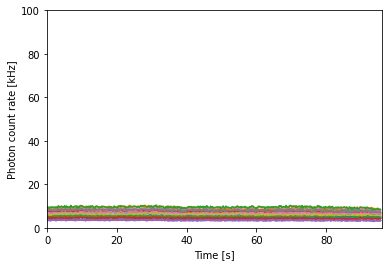

In [10]:
Ndet = 25 # number of channels
totTime = data.macrotime * (np.max(data.det12[:,0]))
print("Measurement duration: " + '{:.0f}'.format(totTime) + " s")

# plot the intensity trace 
Lseg = 0.2
maxseg = int(np.floor(totTime / Lseg))

Nphotons = 0

leg = []
plt.figure()
for det in range(Ndet):
    time = getattr(data, "det" + str(det))[:,0]
    Nphotons += np.shape(time)[0]
    timeAbs = time * data.macrotime
    [Itrace, timeBins] = np.histogram(timeAbs, maxseg)
    plt.plot(timeBins[0:-2], Itrace[0:-1] / (timeBins[2] - timeBins[1]) / 1e3)
    leg.append('det ' + str(det))
plt.xlabel("Time [s]")
#plt.legend(leg)
plt.axis([0, totTime, 0, 100])
output = plt.ylabel("Photon count rate [kHz]")

In [11]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use("seaborn-colorblind")
lineW = 1

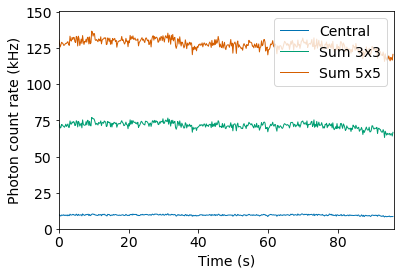

In [12]:
# Plotting the intensity time trace for central channel, inner 3x3 channesl and all channels
#central element
timeAbs = getattr(data, "det12")[:,0] * data.macrotime
[Itrace, timeBins] = np.histogram(timeAbs, maxseg)
plt.plot(timeBins[0:-1], Itrace[0:] / (timeBins[2] - timeBins[1]) / 1e3, linewidth=lineW)

# sum3x3 
ItraceTot = Itrace * 0
for det in [6, 7, 8, 11, 12, 13, 16, 17, 18]:
    timeAbs = getattr(data, "det" + str(det))[:,0] * data.macrotime
    [Itrace, timeBins] = np.histogram(timeAbs, maxseg)
    ItraceTot += Itrace
plt.plot(timeBins[0:-1], ItraceTot[0:] / (timeBins[2] - timeBins[1]) / 1e3, linewidth=lineW)

# sum5x5
ItraceTot = Itrace * 0
for det in range(20):
    timeAbs = getattr(data, "det" + str(det))[:,0] * data.macrotime
    [Itrace, timeBins] = np.histogram(timeAbs, maxseg)
    ItraceTot += Itrace
plt.plot(timeBins[0:-1], ItraceTot[0:] / (timeBins[2] - timeBins[1]) / 1e3, linewidth=lineW)

plt.xlabel("Time (s)")
plt.axis([0, timeBins[-1], 0, 1.1*np.max(ItraceTot[0:] / (timeBins[2] - timeBins[1]) / 1e3)])
output = plt.ylabel("Photon count rate (kHz)")
plt.legend(['Central', 'Sum 3x3', 'Sum 5x5'])
#plt.savefig(os.path.join(Path,fname)+'_FLFS_time_traces.svg', bbox_inches='tight')

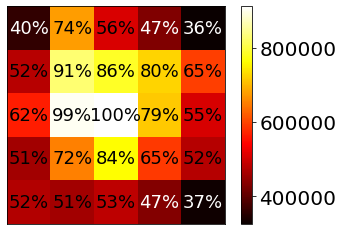

In [13]:
# plotting the detector fingerprint
dummy = plotAiry(data)

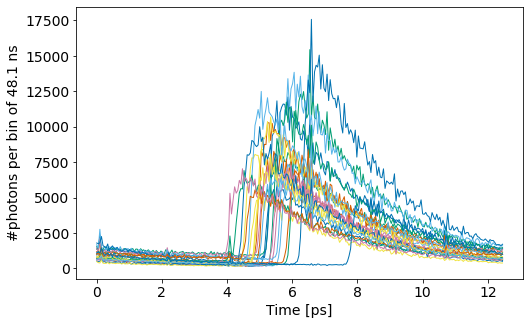

In [14]:
# PLotting the decay histograms 
# Paramenters selection
laserF = 80e6 # laser frequency (Hz)
time_bin_width = 48 #ps


MM = int(np.floor((10e11/laserF)/time_bin_width))
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))
for det in range(Ndet):
    macroTime = getattr(data, "det" + str(det))[:,0] # ps
    microTime = getattr(data, "det" + str(det))[:,1]
    microTime = np.mod(microTime, 1e12 / laserF)
    microTime = -microTime + np.max(microTime)
    [Ihist, lifetimeBins] = np.histogram(microTime, MM)
    lifetimeBins = lifetimeBins[0:-1] * data.microtime * 1e12
    setattr(data, "hist" + str(det), np.transpose(np.stack((lifetimeBins, Ihist))))
    setattr(data, "det" + str(det), np.transpose([macroTime, microTime]))
    lifetimeBinsN = (lifetimeBins - lifetimeBins[0]) / lifetimeBins[1]
    plt.plot(1e-3*lifetimeBins, Ihist, linewidth=lineW)

data.microbintime = 1e-12 * lifetimeBins[1] # s
plt.xlabel("Time [ps]")
output = plt.ylabel("#photons per bin of " + '{:.1f}'.format(lifetimeBins[1]) + " ns")

In [15]:
#Aligning the histograms
data = alignLifetimeHist(data)

In [16]:
fontSize = 20
plt.rcParams.update({'font.size': fontSize})
plt.style.use("seaborn-colorblind")
lineW = 1

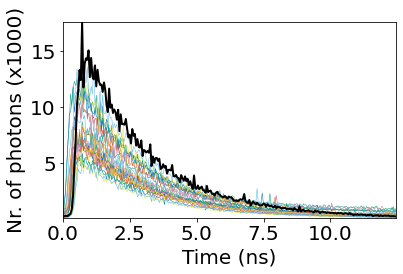

In [17]:
#Plotting the histograms, the central channel is pllotted in bold
plt.figure()
plt.margins(0,0)
for det in range(Ndet):
    histD = getattr(data, "Ahist" + str(det))
    if det != 12:
        plt.plot(1e-3*lifetimeBins, histD[:,1]/1000, linewidth=0.5)

histD = getattr(data, "Ahist" + str(12))
plt.plot(1e-3*lifetimeBins, histD[:,1]/1000, linewidth=lineW*2, color='black')
        

plt.xlabel("Time (ns)")
#plt.axis([0, 25, 0, 3600])
output = plt.ylabel("Nr. of photons (x1000)") # of 43.4 ps
plt.tight_layout()
plt.savefig(filenameOutput+'FLFS_histograms.svg')

In [18]:
# find index peak and zoom
Tmax = 210 # 210
fitRange = np.zeros((Ndet, 2), dtype='int')
for det in range(Ndet):
    IhistSingle = getattr(data, "hist" + str(det)) # number of photons per bin of 43.4 ps as a function of time in ps
    Ihist = IhistSingle[:, 1]
    idxStart = np.where(Ihist == np.max(Ihist))[0][0] + 1
    idxStop = np.where(Ihist[Tmax:] == np.min(Ihist[Tmax:]))[0][0] + Tmax + 1
    idxStop = np.minimum(idxStop, len(Ihist) - 1)
    fitRange[det, :] = [idxStart, idxStop]
    T = idxStop - idxStart
    # print("T = " + str(T))
data.fitRange = fitRange

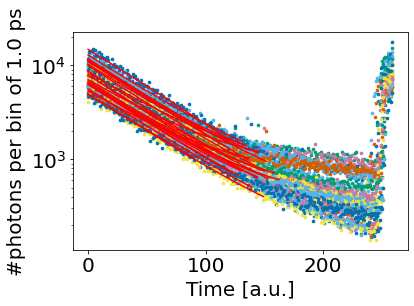

In [19]:
#Fitting the decay histograms with a single exponential model for every detector channel

fitresults = np.zeros((Ndet, 3))

plt.figure()
for det in range(Ndet):
    # get histogram detector element i
    IhistSingle = getattr(data, "hist" + str(det)) # number of photons per bin of 43.4 ps as a function of time in ps
    Ihist = IhistSingle[:, 1]
    lifetimeBins = IhistSingle[:, 0]
    binTime = lifetimeBins[1]
    lifetimeBins /= binTime # bin numbers
    
    [idxStart, idxStop] = data.fitRange[det, :]
    fitRangeL = idxStop - idxStart
    
    Ihist = np.roll(Ihist, -idxStart)
    #lifetimeBins = np.roll(lifetimeBins, -idxStart)
    
    lifetimeBinsFit = (lifetimeBins[0:fitRangeL])
    IhistFit = Ihist[0:fitRangeL]
    
    plt.scatter(lifetimeBins, Ihist, s=7)
    plt.xlabel("Time [a.u.]")
    plt.ylabel("#photons per bin of " + '{:.1f}'.format(lifetimeBins[1]) + " ps")
    #plt.xlim([0, lifetimeBinsFit[-1]])

    # fit exponential
    
    fitresult = fitPowerLaw(IhistFit, lifetimeBinsFit, 'exp', [1, 1, 1], [60000, 4, 100], [0, 0, -1e4], [1e6, 20, 1e6])
    A      = fitresult.x[0]
    alpha  = fitresult.x[1]
    B      = fitresult.x[2]
    plt.plot(lifetimeBinsFit, A * np.exp(-alpha * lifetimeBinsFit) + B, color='r')
    plt.yscale('log')
    
    fitresults[det, :] = [A, alpha, B]
    # output = plt.title("A = " + '{:.0f}'.format(A) + "  -  tau = " + '{:.3f}'.format(1/alpha) + "  -  B = " + '{:.5f}'.format(B/A))

In [20]:
#Average fluorescene lifetime
print("lifetime = (" + '{:.2f}'.format(np.mean(1e9*data.microbintime/fitresults[:, 1])) + " +/- " + '{:.2f}'.format(np.std(1e9*data.microbintime/fitresults[:, 1])) + ") ns")

lifetime = (2.57 +/- 0.07) ns


In [21]:
[idxStart, idxStop]

[169, 259]

### Calculating the Correlations

In [22]:
# Here we are calculating the correlations for no filtered data, for the central channel, the sum of the inner 3x3 and the sum of all detector channels
# The time trace is cutted in several time chunk (split determine the length in seconds of each time chunk).
# Each chunk is correlated with a resolution determined in accuracy.

G = aTimes2CorrsParallel(data, [12, 'sum3','sum5'], accuracy=10, taumax=5/data.macrotime, split=5)

Calculating correlation 12
   Filter 0
Calculating correlation sum3
Extracting and sorting photons
   Filter 0
Calculating correlation sum5
Extracting and sorting photons
   Filter 0


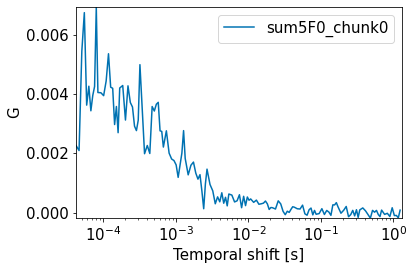

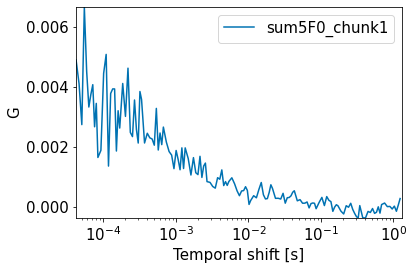

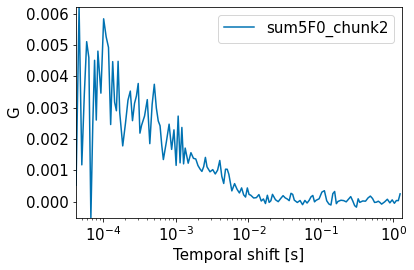

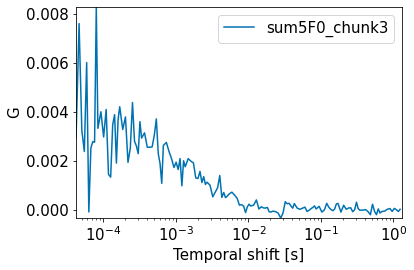

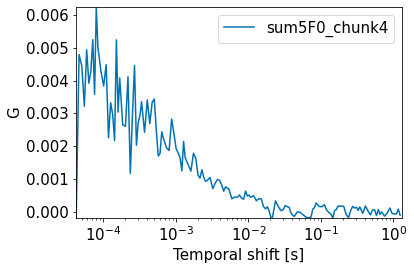

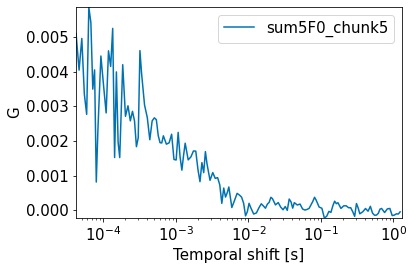

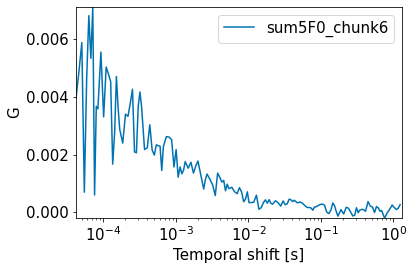

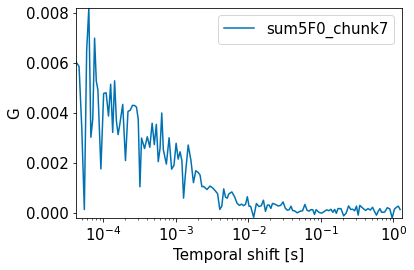

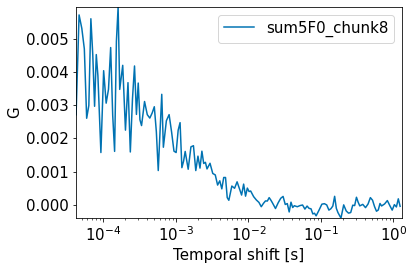

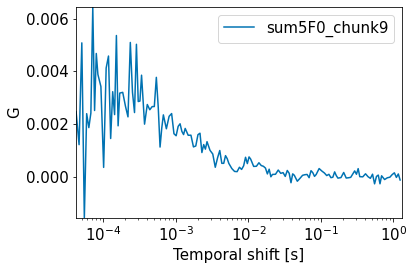

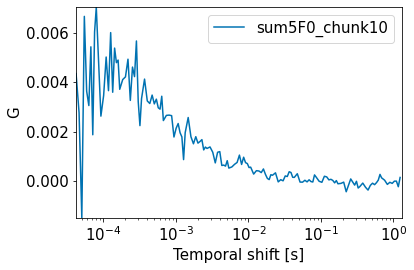

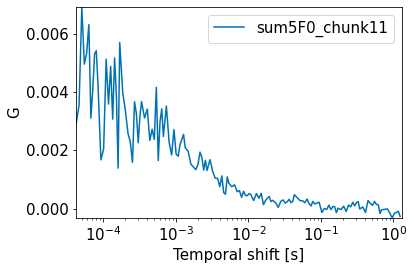

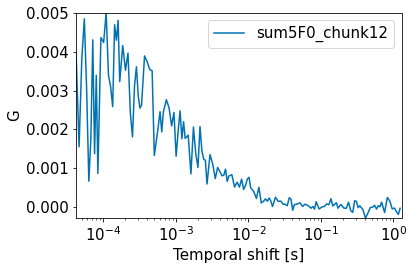

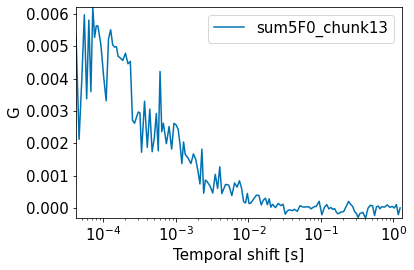

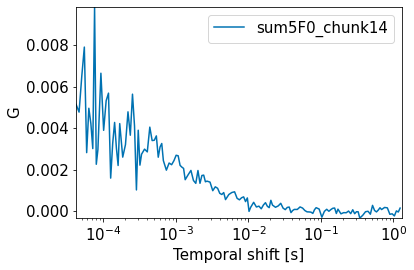

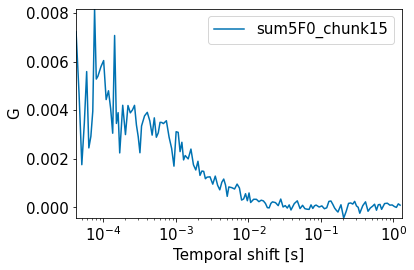

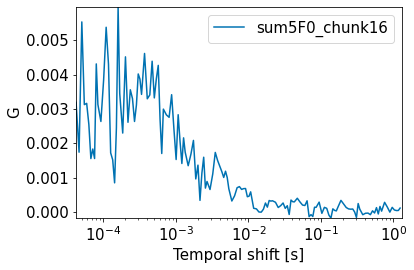

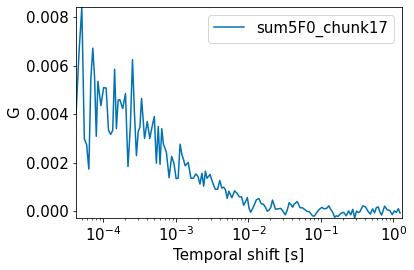

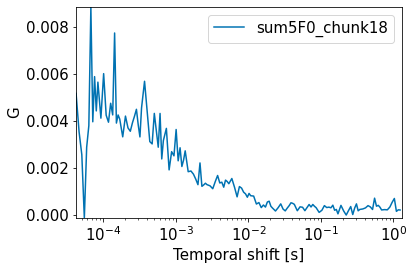

In [23]:
#Plotting the correlations fotr all time chunks (only for sum5), start and stop delimit the starting and the end point of the data to be plotted

start = 220
stop = -20
h = plotFCScorrelations(G, ['sum5F0_chunk0'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk1'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk2'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk3'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk4'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk5'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk6'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk7'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk8'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk9'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk10'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk11'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk12'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk13'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk14'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk15'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk16'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk17'], limits=[start, stop])
h = plotFCScorrelations(G, ['sum5F0_chunk18'], limits=[start, stop])



In [24]:
#Calculate the Average of the correlation curves

Gav_det12F0 = np.mean([G.det12F0_chunk0, G.det12F0_chunk1, G.det12F0_chunk2, G.det12F0_chunk3,G.det12F0_chunk4,G.det12F0_chunk8,G.det12F0_chunk6,G.det12F0_chunk10,G.det12F0_chunk12,G.det12F0_chunk13,G.det12F0_chunk15,G.det12F0_chunk16,G.det12F0_chunk17,G.det12F0_chunk5], axis = 0 )

Gav_sum3F0 = np.mean([G.sum3F0_chunk0,G.sum3F0_chunk1, G.sum3F0_chunk2, G.sum3F0_chunk3,G.sum3F0_chunk4,G.sum3F0_chunk8,G.sum3F0_chunk6,G.sum3F0_chunk10,G.sum3F0_chunk12,G.sum3F0_chunk13,G.sum3F0_chunk16,G.sum3F0_chunk15,G.sum3F0_chunk17,G.sum3F0_chunk5], axis = 0 )

Gav_sum5F0 = np.mean([G.sum5F0_chunk0,G.sum5F0_chunk1, G.sum3F0_chunk2, G.sum5F0_chunk3,G.sum5F0_chunk4,G.sum5F0_chunk8,G.sum5F0_chunk6,G.sum5F0_chunk10,G.sum5F0_chunk12,G.sum5F0_chunk13,G.sum5F0_chunk15,G.sum5F0_chunk16,G.sum5F0_chunk17,G.sum5F0_chunk5], axis = 0 )

## Fitting

------
0.5
tauD = 0.7632832104506203 ms
chi2 = 1.0010305111952134
------
0.5
tauD = 0.6401429530816755 ms
chi2 = 0.09384858300171375
------
0.5
tauD = 0.8076865437480338 ms
chi2 = 0.1999294912986882
tau_D = [0.76328321 0.64014295 0.80768654]ms
D =[17.32646522 32.84422628 31.69546428]um2/s
N = [ 69.40351914 107.64632212 203.54154787]


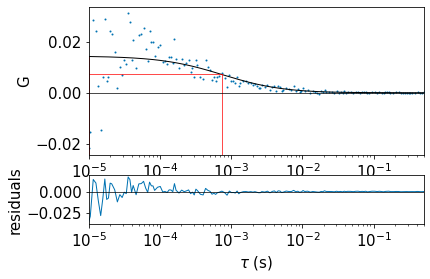

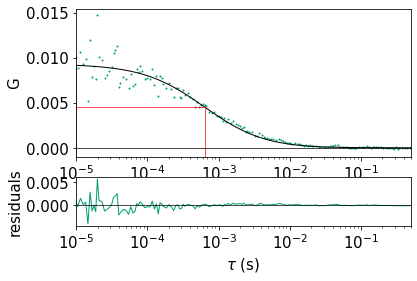

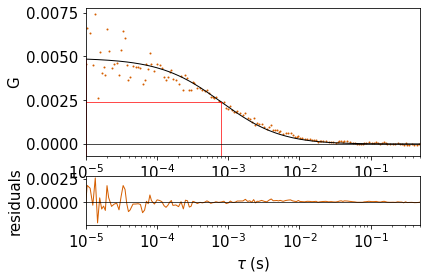

In [25]:
#####----- Fits with my average-------------------

w0 = np.array([230e-9, 290e-9, 320e-9]) # Beam waist, based on the calibration of your setup
SF = np.array([4.5, 4.1, 4.1])

filters = 0
# order of fit parameters: [N, tauD1, tauD2, F, alpha, T, tautrip, SF, offset, A, B]
fitarray = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # parameters to fit
minBound = np.array([0, 5e-4, 5e-4, 0, 0, 0, 0, 0, 0, 0, 0]) # minimum values for the parameters
maxBound = np.array([1e6, 10, 1000, 1, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6, 1e6]) # maximum values for the parameters


# ---------- central element ----------
det = 12
startValues = np.array([70, 0.4, 5e-8, 1, 1, 0, 1e-6, SF[0], 0, 0, 1.05]) # start values for the fit
plotInfo = "C0" # used for the color of the output plot
Gsingle = getattr(G, 'det12F' + str(filters) + '_average')
Gexp = Gsingle[:, 1]
tau = Gsingle[:, 0]
[dummy, start] = findNearest(tau, 10e-6)
[dummy, stop] = findNearest(tau, 20)

fitresult1 = FCSfit(Gav_det12F0[:,1][start:stop], tau[start:stop], 'fitfun2C', fitarray, startValues,  minBound, maxBound, plotInfo, 0, 0)

# ---------- sum3x3 ----------
startValues = np.array([70, 0.4, 5e-8, 1, 1, 0, 1e-6, SF[1], 0, 0, 1.05]) # start values for the fit
plotInfo = "C1"
Gsingle = getattr(G, 'sum3F' + str(filters) + '_average')
Gexp = Gsingle[:, 1]
tau = Gsingle[:, 0]
fitresult3 = FCSfit(Gav_sum3F0[:,1][start:stop], tau[start:stop], 'fitfun2C', fitarray, startValues,  minBound, maxBound, plotInfo, 0, 0)

# ---------- sum5x5 ----------
startValues = np.array([70, 0.4, 5e-10, 1, 1, 0, 1e-6, SF[2], 0, 0, 1.05]) # start values for the fit
plotInfo = "C2"
Gsingle = getattr(G, 'sum5F' + str(filters) + '_average')
Gexp = Gsingle[:, 1]
tau = Gsingle[:, 0]
fitresult5 = FCSfit(Gav_sum5F0[:,1][start:stop], tau[start:stop], 'fitfun2C', fitarray, startValues,  minBound, maxBound, plotInfo, 0, 0)



tauD = 1e-3 * np.array([fitresult1.x[1], fitresult3.x[1], fitresult5.x[1]])
Dfit = w0**2 / 4 / ( tauD)

N =  np.array([fitresult1.x[0], fitresult3.x[0], fitresult5.x[0]])

print("tau_D = " + str(tauD*1.0e3) + "ms")
print("D =" + str(Dfit*1.0e12) + "um2/s" )

print("N = " + str(N) )


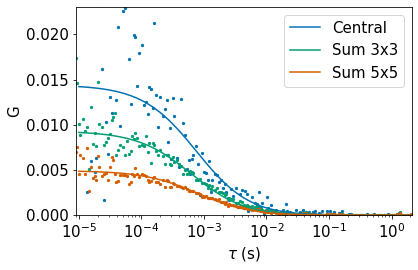

In [26]:
plt.figure()
markerSize = 5
# central
plt.scatter(G.det12F0_average[:,0], Gav_det12F0[:,1], s = markerSize)
plt.plot(G.det12F0_average[start:stop,0], Gav_det12F0[start:stop,1] - fitresult1.fun, label='Central')
# sum 3
plt.scatter(G.sum3F0_average[:, 0], Gav_sum3F0[:, 1], s = markerSize)
plt.plot(G.sum3F0_average[start:stop,0], Gav_sum3F0[start:stop,1] - fitresult3.fun, label='Sum 3x3')
# sum 5
plt.scatter(G.sum5F0_average[:, 0], Gav_sum5F0[:,1], s = markerSize)
plt.plot(G.sum5F0_average[start:stop,0], Gav_sum5F0[start:stop,1] - fitresult5.fun, label='Sum 5x5')
plt.xscale('log')
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'G')
plt.legend(fontsize=15)
plt.tight_layout()
plt.axis([9e-6, 2.1, 0, 0.023])
plt.savefig(filenameOutput+'_3curves.svg')
plt.savefig(filenameOutput+'_3curves.png')